In [114]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
np.random.seed(0)

# Data import

In [115]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,Unnamed: 0,index,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,0,69.662,51.452,65.784,2.436999,0.000,0.000,0.000,2.170,...,119.414310,-8.062065,-36.531986,-22.289234,38.641340,100.352905,37.411,0.0,0,0.000123
1,1,1,99.593,77.723,72.034,0.413001,0.000,0.000,0.000,2.700,...,12.693051,-28.446564,-11.507551,-22.373512,11.807400,-6.208095,30.686,0.0,0,0.000148
2,2,2,211.403,7.605,94.500,15.523002,0.000,0.000,0.000,3.011,...,122.467400,74.160330,-12.882871,-84.717210,11.557951,481.350770,75.271,1.0,0,0.000044
3,3,3,110.021,0.417,80.155,108.818000,3.178,400.500,-2.501,1.619,...,161.720460,15.490204,0.294349,1.039680,97.977486,336.323300,15.493,3.0,0,0.000002
4,4,4,143.446,6.424,89.514,98.435000,6.501,1527.531,-10.477,2.847,...,86.661575,62.066280,-6.541016,-24.217790,12.503346,4.296636,62.410,2.0,1,0.000028


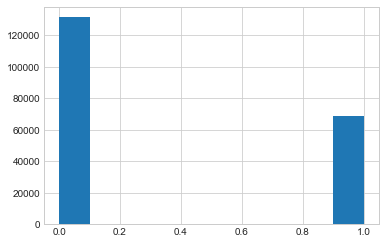

In [116]:
train_df.gen_target.hist()

In [117]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.65733, 0.34267)

In [118]:
size = 224

In [119]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='Unnamed: 0',
                              bs=128, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'images', folder='train', suffix='.png').normalize(imagenet_stats)

In [120]:
data

ImageDataBunch;

Train: LabelList (160000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,1
Path: /home/giles/Documents/kaggle/higgsml/images;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,0,0,0
Path: /home/giles/Documents/kaggle/higgsml/images;

Test: None

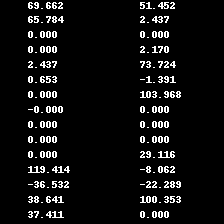

In [121]:
data.train_ds[0][0]

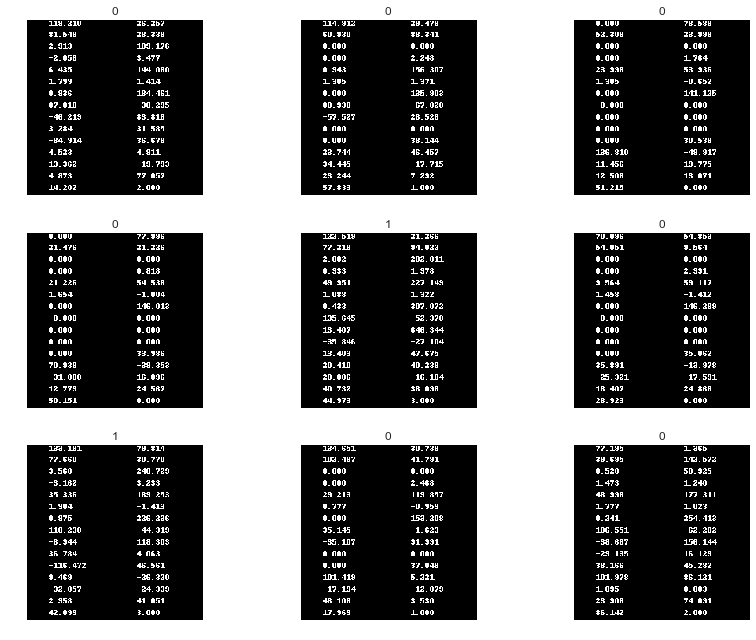

In [122]:
data.show_batch(rows=3, figsize=(12,9))

# Model training

In [123]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [124]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


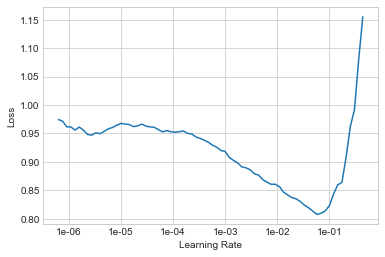

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.468897,0.447125,0.207550,05:09
1,0.410617,0.414699,0.193675,05:09
2,0.400944,0.394477,0.179750,05:10
3,0.376001,0.392472,0.179625,05:11


In [20]:
learn.save('stage-1')

In [21]:
learn.unfreeze()

In [22]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


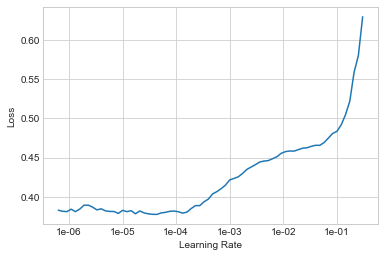

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(3e-7,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.376136,0.391925,0.178050,06:55
1,0.378226,0.389366,0.177500,06:57
2,0.376526,0.387823,0.175525,06:54
3,0.357384,0.389191,0.176600,06:53
4,0.341507,0.394077,0.176750,06:57
5,0.330267,0.398329,0.179350,07:01
6,0.311021,0.401000,0.179650,06:58
7,0.319425,0.401730,0.179475,06:54


In [26]:
learn.save('stage-2')

In [85]:
learn.export()

# Inference

## Validation

In [99]:
val_df = pd.read_csv(IMG_PATH/'val.csv'); len(val_df); val_df.head()

,Unnamed: 0,index,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,0,98.784,0.574002,67.028,30.797000,0.000,0.000,0.000,2.994,...,145.127000,16.534410,0.429992,-18.502205,12.592758,17.146720,16.540,1.0,0,1.373391
1,1,1,82.320,2.403000,55.836,22.090998,0.000,0.000,0.000,2.982,...,30.621115,12.101365,1.508308,-21.806877,5.693990,3.074624,12.195,1.0,1,0.001503
2,2,2,120.690,97.007000,60.179,38.388000,0.000,0.000,0.000,2.590,...,29.813047,-56.103783,5.482270,-19.775946,12.244983,12.674190,56.371,0.0,0,4.668122
3,3,3,148.487,79.310000,113.533,31.527000,0.000,0.000,0.000,3.349,...,28.878614,-16.097530,-25.778736,-28.960590,3.739328,93.065650,30.392,1.0,0,2.602222
4,4,4,107.535,12.780998,69.843,20.366999,4.363,360.453,-4.759,3.249,...,59.702408,15.327226,10.284644,-29.358150,6.152965,5.215232,18.458,2.0,0,0.307170


In [87]:
val_lst = ImageList.from_df(val_df, IMG_PATH/'images', folder='val', suffix='.png')

In [88]:
learn = load_learner(IMG_PATH/'images', test=val_lst)

In [89]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [100]:
val_df['pred'] = to_np(multiclass2binary(preds))

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


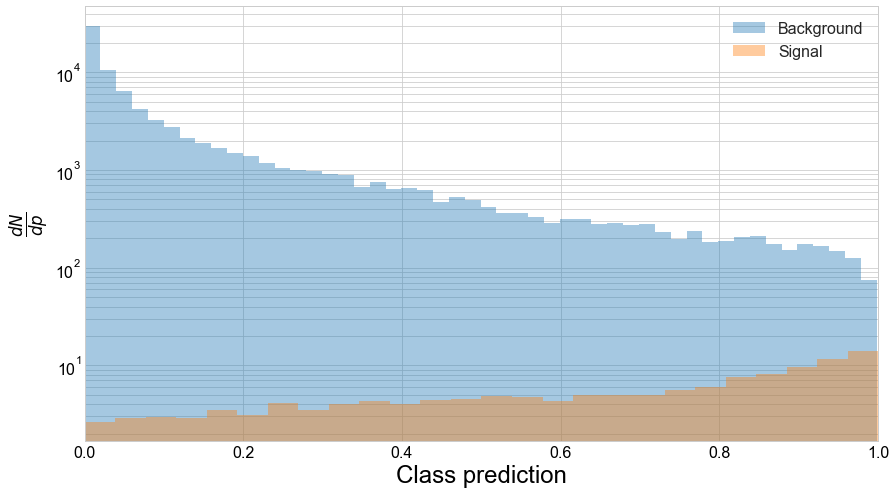

In [97]:
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

Mean cut at 0.8828670978546143 corresponds to AMS of 2.80037325787677
Maximum AMS for data is 2.910144879084534 at cut of 0.8618935346603394


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


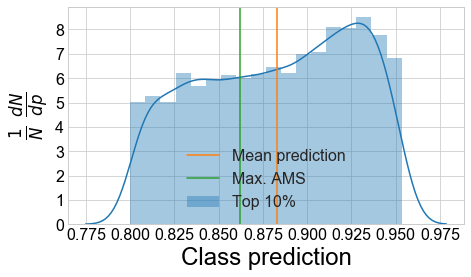

In [101]:
cut, smooth_ams, max_ams = binary_class_cut(val_df, top_perc=10, br=10, wgt_factor=250000/50000, min_pred=0.8)

## Test

In [102]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,Unnamed: 0,index,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,0,0.000,79.589,23.916,3.036002,0.00,0.000,0.000,0.903,...,17.833948,-44.840416,-18.505684,13.695490,17.329550,12.515708,48.509000,0.0,0,11.246676
1,1,1,117.794,56.226,96.358,4.137000,0.00,0.000,0.000,2.755,...,29.388700,-11.515666,-15.688212,-42.913760,18.072498,14.082360,19.461002,0.0,1,0.010415
2,2,2,135.861,30.604,97.288,9.103999,0.00,0.000,0.000,2.811,...,12.681531,14.081906,-20.815070,-47.361390,20.833385,-20.583021,25.131000,0.0,1,0.010415
3,3,3,429.273,75.057,234.610,71.019000,0.59,174.261,2.278,4.287,...,148.486480,-15.265509,46.786560,-23.113087,24.057049,-84.193400,49.214000,2.0,0,1.582617
4,4,4,96.033,43.116,59.270,5.141001,0.00,0.000,0.000,3.131,...,18.655660,-12.263648,3.032429,-22.059671,1.157146,25.519249,12.633001,0.0,0,0.932279


In [103]:
test_lst = ImageList.from_df(test_df, IMG_PATH/'images', folder='test', suffix='.png')

In [104]:
learn = load_learner(IMG_PATH/'images', test=test_lst)

In [105]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [106]:
test_df['pred'] = to_np(multiclass2binary(preds))

with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
cont_feats = feats['cont_feats']
cat_feats = feats['cat_feats']    
cat_maps = feats['cat_maps']  
cat_szs = feats['cat_szs']  
train_feats = cont_feats + cat_feats

test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"), cont_feats, cat_feats)

test_df['private'] = test_fy.get_column('private')

In [113]:
test_df.head()

,Unnamed: 0,index,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_py,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,pred,private
0,0,0,0.000,79.589,23.916,3.036002,0.00,0.000,0.000,0.903,...,-18.505684,13.695490,17.329550,12.515708,48.509000,0.0,0,11.246676,0.004797,0
1,1,1,117.794,56.226,96.358,4.137000,0.00,0.000,0.000,2.755,...,-15.688212,-42.913760,18.072498,14.082360,19.461002,0.0,1,0.010415,0.708606,1
2,2,2,135.861,30.604,97.288,9.103999,0.00,0.000,0.000,2.811,...,-20.815070,-47.361390,20.833385,-20.583021,25.131000,0.0,1,0.010415,0.926629,1
3,3,3,429.273,75.057,234.610,71.019000,0.59,174.261,2.278,4.287,...,46.786560,-23.113087,24.057049,-84.193400,49.214000,2.0,0,1.582617,0.004504,1
4,4,4,96.033,43.116,59.270,5.141001,0.00,0.000,0.000,3.131,...,3.032429,-22.059671,1.157146,25.519249,12.633001,0.0,0,0.932279,0.778205,1


In [112]:
score_test_df(test_df, cut)

Public:Private AMS: 2.7864904462870794 : 2.7419506623983185


(2.7864904462870794, 2.7419506623983185)